# Plote alle Resultate

In [1]:
# Importe definieren
import pandas as pd
import google.colab
from google.colab import drive
import plotly
import plotly.express as px
import folium
from folium.plugins import HeatMap
import branca
import branca.colormap as cm
import matplotlib
import matplotlib.pyplot as plt

print(f'pandas {pd.__version__}')
print(f'google.colab {google.colab.__version__}')
print(f'plotly {plotly.__version__}')
print(f'folium {folium.__version__}')
print(f'branca {branca.__version__}')
print(f'matplotlib {matplotlib.__version__}')

# numpy 1.21.6
# pandas 1.3.5
# google.colab 0.0.1a2
# plotly 5.5.0
# folium 0.8.3
# branca 0.5.0
# matplotlib 3.2.2

pandas 1.3.5
google.colab 0.0.1a2
plotly 5.5.0
folium 0.8.3
branca 0.5.0
matplotlib 3.2.2


In [2]:
# Google Drive für Dateizugriff mounten
google_drive = True

if google_drive:
  drive.mount('/content/drive', force_remount=True)
  gdriveroot = '/content/drive/MyDrive/'
else:
  # Gewünschten Pfad setzen wenn Google Drive NICHT verwendet wird
  gdriveroot = ''

!ls {gdriveroot}

meinpfad = gdriveroot + 'ScriptingProjekt/data/'

Mounted at /content/drive
ScriptingProjekt


## Plot die Messstationen, Gemeinde Zentren mit dazugehörigen Rasterpunkte und den HGT Resultaten

Aufbereiteter Referenzdatensatz vom HEV darstellen

Der aufbereitete Referenzdatensatz vom HEV wird auf einer Karte dargestellt. Jede Wetterstation erhält einen Marker mit Zusatzinformationen und Link zu den Messwerten bei MeteoSchweiz.

In [ ]:
df_geo_hgt = pd.read_csv(meinpfad + 'ready/df_geo_hgt.csv')

fig = px.scatter_mapbox(df_geo_hgt, lat="lat", lon="lon", hover_name="GMDNAME", hover_data=["HGT"],
                        color='Art', size = [2]*len(df_geo_hgt) , zoom=6.5, height=800)
fig.update_layout(mapbox_style="open-street-map")
fig.update_layout(margin={"r":0,"t":0,"l":0,"b":0})
fig.show()

# Aufbereitete Daten der Wetterstationen mit den HGT Referenzen vom 

Ausgabe verschiedener Darstellungen der HEV Referenzdaten mit den jeweiligen Wetterstationen.

## Karte mit Wetterstationen und der HGT Referenz vom HEV (Folium)

Darstellung aller Wetterstationen auf der Karte mit Informationen zur Höhe, HGT Referenzwerten vom HEV sowie Link zur Wetterstationen bei Meteo Schweiz.
Die Farbe des Symbols korrespondiert zum HGT Wert (rot = tief, blau = hoch)


In [ ]:
# Aufbereitete HEV Referenz in DataFrame laden
df_hevreferenz = pd.read_csv(meinpfad + 'ready/hevreferenz.csv', index_col=['Station_MAP'])
# print(df_hevreferenz.head())

# Karte definieren
map_hevreferenz = folium.Map(
    location=[df_hevreferenz.Breitengrad.mean(), df_hevreferenz.Längengrad.mean()], 
    zoom_start=8, 
    control_scale=True,
    tiles ='Stamen Terrain'
    )

# Titel hinzufügen
title_css = ''' 
  letter-spacing: 2px;
  word-spacing: 2px;
  color: #75BF7F;
  font-weight: 900;
  -webkit-text-stroke: 1.4px #444;
  text-shadow: 1px 1px 2px black;
'''
title_html = f'''
             <h1 align="center" style="{title_css}">Wetterstationen mit Referenzwerten</h1>
             '''

map_hevreferenz.get_root().html.add_child(folium.Element(title_html))

# Wärmekarten-Ebene erstellen mit Wert von hgt als Gewichtung (Weight)
HeatMap(
    list(zip(df_hevreferenz['Breitengrad'], df_hevreferenz['Längengrad'], df_hevreferenz['Ref_HGT_2011_2020'])),
    min_opacity=0.2,
    max_val=df_hevreferenz['Ref_HGT_2011_2020'].max(),
    radius=50, 
    blur=50, 
    max_zoom=1).add_to(folium.FeatureGroup(name='Heat Map',show=False).add_to(map_hevreferenz))

# Wärmekarten-Ebene der Basiskarte hinzufügen
folium.LayerControl().add_to(map_hevreferenz)

# Colormap für die Farbe des Markers definieren
vmin = df_hevreferenz.Ref_HGT_2011_2020.min()
vmax = df_hevreferenz.Ref_HGT_2011_2020.max()
colormap = cm.LinearColormap(colors=['red', 'blue'], vmin=vmin, vmax=vmax)

# Marker mit Wetterstationen hinzufügen
for index, location_info in df_hevreferenz.iterrows():
    # Position festlegen
    latitude = location_info['Breitengrad']
    longitude = location_info['Längengrad']
    # Information im Marker Popup definieren
    info = '<b><a target="_blank" href=' + location_info['Link']+ '>' + location_info['Station'] + ' / ' + location_info['Kanton'] + '</a></b>'
    info += '<br />' + str(location_info['Stationshöhe m. ü. M.']) + ' m.ü.M.'
    info += '<br />' + str(location_info['Ref_HGT_2011_2020']) + ' HGT 20/12'
    inhalt = folium.Html(info, script=True)
    popup = folium.Popup(inhalt, max_width=300)
    # Farbe des Marker Icons definieren 
    # Farbe des Markericons aufgrund des HGT Werts in einem Verlauf von Rot nach Blau berechnen
    # Marker Farbe lässt sich leider nicht festlegen :-(
    farbe = colormap(location_info['Ref_HGT_2011_2020'])
    icon = folium.Icon(color='beige', icon_color=farbe, icon='plus-sign')
    # Marker hinzufügen
    folium.Marker([latitude, longitude], popup=popup, icon=icon).add_to(map_hevreferenz)

# Karte ausgeben
map_hevreferenz  

## Karte mit Wetterstationen und der HGT Referenz vom HEV (Plotly)

Dieselbe Darstellung wie oben, hier mit Plotly Express realisiert. Der Marker beinhaltet zwei Dimensionen, die Grösse steht im Verhältnis zur Höhe der Wetterstation, die Farbe zum HGT Wert. Die Legende ist einfacher gehalten als bei Folium.

In [ ]:
df = df_hevreferenz

fig = px.scatter_mapbox(
    df, lat="Breitengrad", lon="Längengrad",
    title="Wetterstationen mit Referenzwerten",
    color="Ref_HGT_2011_2020", size="Stationshöhe m. ü. M.",
    #color_continuous_scale=px.colors.cyclical.IceFire, 
    color_continuous_scale=px.colors.sequential.Bluered_r,
    size_max=15, 
    zoom=7,
    hover_name = "Station",
    hover_data = ["Ref_HGT_2011_2020", "Stationshöhe m. ü. M.", "Kanton"]
    )

# fig.update_layout(mapbox_style="open-street-map")
fig.update_layout(mapbox_style="stamen-terrain")
fig.update_layout(margin={"r":0,"t":40,"l":0,"b":0})

fig.show()

## Diagram mit den Höhen der Wetterstationen und den HGT Werten 

Die Höhe der Wetterstationen und die HGT Werten korrespondieren mehrheitlich miteinander. Im Süden sind die HGT Werte bei ähnlichen Höhen jedoch tiefer. 

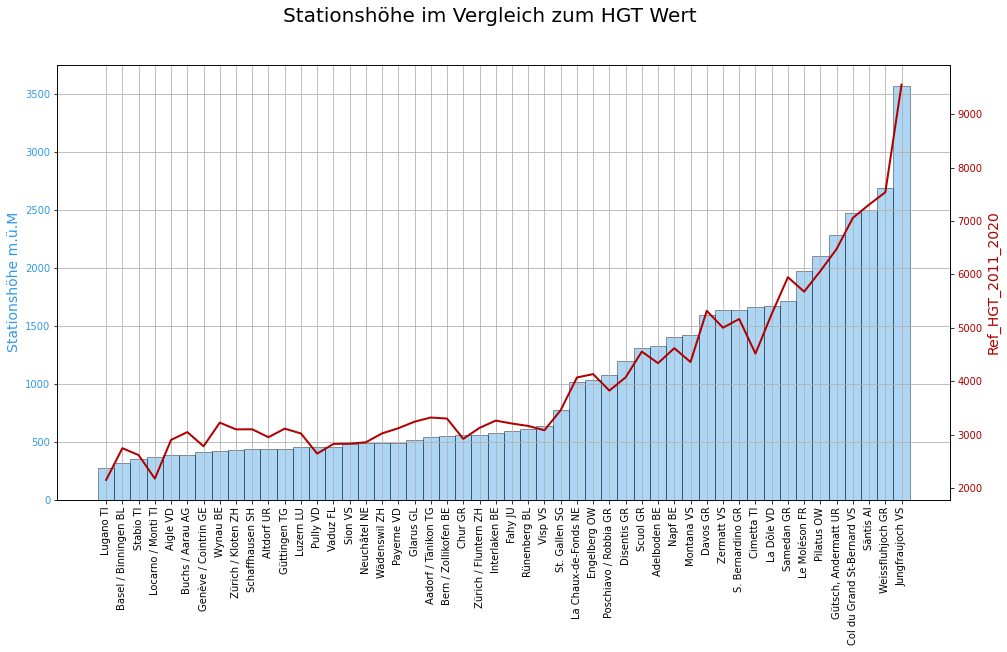

In [ ]:
df = df_hevreferenz.sort_values(by=['Stationshöhe m. ü. M.'])
df['Station Kanton'] = df['Station'] + ' ' + df['Kanton']
station=df['Station Kanton'].to_numpy()
hgt=df['Ref_HGT_2011_2020'].to_numpy()
hoehe=df['Stationshöhe m. ü. M.'].to_numpy()
hoehe=hoehe.astype(int)

COLOR_HOEHE = "#3399e6"
COLOR_HGT = "#b00000"

fig, ax1 = plt.subplots(figsize=(16, 8))
ax2 = ax1.twinx()

ax1.set_ylabel("Stationshöhe m.ü.M", color=COLOR_HOEHE, fontsize=14)
ax1.tick_params(axis="y", labelcolor=COLOR_HOEHE)

ax2.set_ylabel("Ref_HGT_2011_2020", color=COLOR_HGT, fontsize=14)
ax2.tick_params(axis="y", labelcolor=COLOR_HGT)

ax1.grid()
ax2.grid(axis = 'x')

# ax1.plot(station, hoehe, color=COLOR_HOEHE, lw=3)
ax1.bar(station, hoehe, color=COLOR_HOEHE, edgecolor="black", alpha=0.4, width=1.0)
ax2.plot(station, hgt, color=COLOR_HGT, lw=2);

fig.suptitle("Stationshöhe im Vergleich zum HGT Wert", fontsize=20)

plt.draw()
ax1.set_xticklabels(ax1.get_xticklabels(), rotation = 90)

# Show the graph
plt.show()

# Darstellung aller Gemeinden auf einer Karte

Datensatz der Gemeinden auf einer Karte ausgeben für die visuelle Überprüfung. Die Farbe des Markers korrespondiert zur Höhe des Gemeindezentrums.

In [ ]:
# Alle Gemeinden auf einer Karte ausgeben für die visuelle Überprüfung der Daten

# Aufbereitete Gemeinden in DataFrame laden
#df_gmd = pd.read_csv(meinpfad + 'ready/Gemeinden_Koord_fin.csv', sep=';', index_col=['GMDNAME'])
df_gmd = pd.read_csv(meinpfad + 'ready/df_gmd.csv', sep=';', index_col=['GMDNAME'])
# print(df_gmd.head())

# Karte definieren
map_gmd = folium.Map(
    location=[df_gmd.E_CNTR.mean(), df_gmd.N_CNTR.mean()], 
    zoom_start=8, 
    control_scale=True,
    tiles ='Stamen Terrain'
    )

vmin = df_gmd.Z_CNTR.min() * 1.4 # Faktor um tief- und hochgelegene Gemeinden besser sichtbar zu machen
vmax = df_gmd.Z_CNTR.max() / 1.4
vmax_gmd = df_gmd[['Z_CNTR']].idxmax()[0]
vmin_gmd = df_gmd[['Z_CNTR']].idxmin()[0]
colormap = cm.LinearColormap(colors=['yellow', 'darkred'], vmin=vmin, vmax=vmax)
colormap.caption = f'Höhe des Gemeindezentrums ({vmin_gmd} {df_gmd.Z_CNTR.min()} m.ü.M - {vmax_gmd} {df_gmd.Z_CNTR.max()} m.ü.M )'
map_gmd.add_child(colormap)

# Marker mit Gemeinden hinzufügen
for index, location_info in df_gmd.iterrows():
    # Position festlegen
    latitude = location_info['E_CNTR']
    longitude = location_info['N_CNTR']
    # Information im Marker Popup definieren
    info = '<b>' + index + '</b>'
    info += '<br />Höhe Zentrum ' + str(location_info['Z_CNTR']) + ' m.ü.M.'
    info += '<br />Höhe Gemeinde ' + str(location_info['Z_MIN']) + ' - ' + str(location_info['Z_MAX']) + ' m.ü.M.'
    info += '<br />Fläche ' + str(location_info['AREA_HA']) + ' ha'
    inhalt = folium.Html(info, script=True)
    popup = folium.Popup(inhalt, max_width=300)
    # Marker hinzufügen
    # folium.Marker([latitude, longitude], popup=popup).add_to(map_gmd)
    color = colormap(location_info['Z_CNTR'])
    folium.Circle(location=[latitude, longitude], radius=1000, fill=True ,popup=popup, color=color).add_to(map_gmd)

# Karte ausgeben
map_gmd  

# Plot für die Abweichung der Berechneten HGT-Werten zu den Referenz HGT-Werten des Hauseigentümerverbandes.

In [6]:
df_Vergleich = pd.read_csv(meinpfad + 'ready/Vergleich_HGT.csv', index_col=[0])
df_Vergleich.head()

Station  Ref_HGT_2011_2020    GMDNAME  GMD_Z_CENTR   HGT_temp   hgtdiff  \
32      Vaduz               2825      Vaduz        626.0  3241.3447 -416.3447   
0   Adelboden               4338  Adelboden       1356.0  4824.1885 -486.1885   
17     Lugano               2151     Lugano        276.0  2371.1190 -220.1190   
30     Stabio               2616     Stabio        356.0  2878.8694 -262.8694   
28       Sion               2830       Sion        512.0  3107.1680 -277.1680   

    hgtdiff_Pr  
32  -14.737865  
0   -11.207665  
17  -10.233333  
30  -10.048524  
28   -9.793922

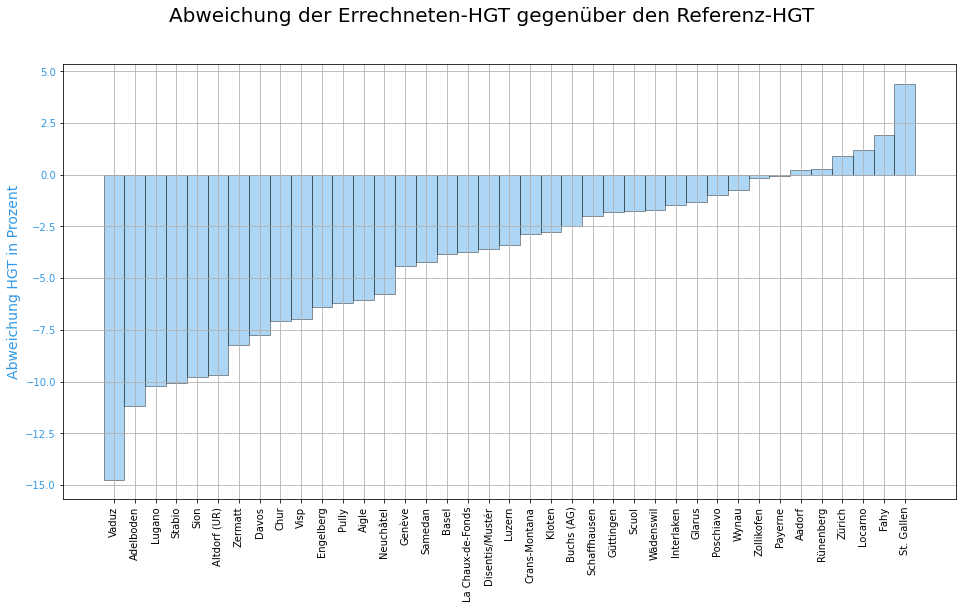

In [9]:
# Sortierung des Dataframe und zuweisung zu Vektoren zur Erstellung des Plots
df_Vergleich = df_Vergleich.sort_values(by=['hgtdiff_Pr'])
station=df_Vergleich['Station'].to_numpy()
hgtdiff_Pr=df_Vergleich['hgtdiff_Pr'].to_numpy()

COLOR_hgtdiff_Pr = "#3399e6"

fig, ax1 = plt.subplots(figsize=(16, 8))
ax1.set_ylabel("Abweichung HGT in Prozent", color=COLOR_hgtdiff_Pr, fontsize=14)
ax1.tick_params(axis="y", labelcolor=COLOR_hgtdiff_Pr)

ax1.grid()
ax2.grid(axis = 'x')

ax1.bar(station, hgtdiff_Pr, color=COLOR_hgtdiff_Pr, edgecolor="black", alpha=0.4, width=1.0)

fig.suptitle("Abweichung der Errechneten-HGT gegenüber den Referenz-HGT ", fontsize=20)

plt.draw()
ax1.set_xticklabels(ax1.get_xticklabels(), rotation = 90)

# Show the graph
plt.show()